In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from scipy.stats import wasserstein_distance, entropy
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from umap import UMAP
from matplotlib import pyplot as plt
import seaborn as sns
import faiss

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')
run_stats = {}

In [2]:
# parameters
dataset_name = ""
model_name = "flow_ss_vcr_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "MNIST"
ood = ""


In [4]:
# initialize data attributes and loaders
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data(shuffle_training_data=False)
config.print_labels()
dm = config.datamodule

assert dm

  0%|                                                                                                                                                       | 0/60000 [00:00<?, ?it/s]

 12%|████████████████▌                                                                                                                        | 7265/60000 [00:00<00:00, 72642.10it/s]

 24%|████████████████████████████████▉                                                                                                       | 14530/60000 [00:00<00:00, 70568.42it/s]

 36%|█████████████████████████████████████████████████▍                                                                                      | 21795/60000 [00:00<00:00, 71498.89it/s]

 48%|█████████████████████████████████████████████████████████████████▉                                                                      | 29089/60000 [00:00<00:00, 72060.75it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████▎                                                     | 36298/60000 [00:00<00:00, 71271.27it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 43580/60000 [00:00<00:00, 71788.96it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 50879/60000 [00:00<00:00, 72176.41it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 58099/60000 [00:00<00:00, 72161.95it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60000/60000 [00:00<00:00, 71728.95it/s]

  0%|                                                                                                                                                       | 0/10000 [00:00<?, ?it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████▏                                                | 6438/10000 [00:00<00:00, 64373.15it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 63422.83it/s]

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

 dqkmlnla


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb:   1 of 1 files downloaded.  


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_e_u = []
    trn_e_v = []
    trn_rcn = []
    trn_tgt = []

    val_inp = []
    val_e_u = []
    val_e_v = []
    val_rcn = []
    val_tgt = []

    ind_inp = []
    ind_e_u = []
    ind_e_v = []
    ind_rcn = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_e_u = []
        ood_e_v = []
        ood_rcn = []
        ood_tgt = []

    rnd_inp = []
    rnd_e_u = []
    rnd_e_v = []
    rnd_rcn = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_e_u.extend(e_u.detach().cpu().numpy())
        trn_e_v.extend(e_v.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_e_u.extend(e_u.detach().cpu().numpy())
        val_e_v.extend(e_v.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_e_u.extend(e_u.detach().cpu().numpy())
        ind_e_v.extend(e_v.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_e_u.extend(e_u.detach().cpu().numpy())
            ood_e_v.extend(e_v.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_e_u.extend(e_u.detach().cpu().numpy())
        rnd_e_v.extend(e_v.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                                                                         | 0/375 [00:00<?, ?it/s]

  0%|▍                                                                                                                                                | 1/375 [00:01<07:23,  1.18s/it]

  1%|█▏                                                                                                                                               | 3/375 [00:01<02:09,  2.88it/s]

  1%|█▉                                                                                                                                               | 5/375 [00:01<01:12,  5.09it/s]

  2%|██▋                                                                                                                                              | 7/375 [00:01<00:49,  7.36it/s]

  2%|███▍                                                                                                                                             | 9/375 [00:01<00:38,  9.55it/s]

  3%|████▏                                                                                                                                           | 11/375 [00:01<00:31, 11.50it/s]

  3%|████▉                                                                                                                                           | 13/375 [00:01<00:27, 13.16it/s]

  4%|█████▊                                                                                                                                          | 15/375 [00:01<00:24, 14.51it/s]

  5%|██████▌                                                                                                                                         | 17/375 [00:02<00:22, 15.58it/s]

  5%|███████▎                                                                                                                                        | 19/375 [00:02<00:21, 16.38it/s]

  6%|████████                                                                                                                                        | 21/375 [00:02<00:20, 16.98it/s]

  6%|████████▊                                                                                                                                       | 23/375 [00:02<00:20, 17.42it/s]

  7%|█████████▌                                                                                                                                      | 25/375 [00:02<00:19, 17.74it/s]

  7%|██████████▎                                                                                                                                     | 27/375 [00:02<00:19, 17.96it/s]

  8%|███████████▏                                                                                                                                    | 29/375 [00:02<00:19, 18.13it/s]

  8%|███████████▉                                                                                                                                    | 31/375 [00:02<00:18, 18.24it/s]

  9%|████████████▋                                                                                                                                   | 33/375 [00:02<00:18, 18.33it/s]

  9%|█████████████▍                                                                                                                                  | 35/375 [00:03<00:18, 18.38it/s]

 10%|██████████████▏                                                                                                                                 | 37/375 [00:03<00:18, 18.44it/s]

 10%|██████████████▉                                                                                                                                 | 39/375 [00:03<00:18, 18.46it/s]

 11%|███████████████▋                                                                                                                                | 41/375 [00:03<00:18, 18.49it/s]

 11%|████████████████▌                                                                                                                               | 43/375 [00:03<00:17, 18.51it/s]

 12%|█████████████████▎                                                                                                                              | 45/375 [00:03<00:17, 18.52it/s]

 13%|██████████████████                                                                                                                              | 47/375 [00:03<00:17, 18.52it/s]

 13%|██████████████████▊                                                                                                                             | 49/375 [00:03<00:17, 18.54it/s]

 14%|███████████████████▌                                                                                                                            | 51/375 [00:03<00:17, 18.55it/s]

 14%|████████████████████▎                                                                                                                           | 53/375 [00:03<00:17, 18.53it/s]

 15%|█████████████████████                                                                                                                           | 55/375 [00:04<00:17, 18.53it/s]

 15%|█████████████████████▉                                                                                                                          | 57/375 [00:04<00:17, 18.52it/s]

 16%|██████████████████████▋                                                                                                                         | 59/375 [00:04<00:17, 18.51it/s]

 16%|███████████████████████▍                                                                                                                        | 61/375 [00:04<00:16, 18.51it/s]

 17%|████████████████████████▏                                                                                                                       | 63/375 [00:04<00:16, 18.52it/s]

 17%|████████████████████████▉                                                                                                                       | 65/375 [00:04<00:16, 18.51it/s]

 18%|█████████████████████████▋                                                                                                                      | 67/375 [00:04<00:16, 18.53it/s]

 18%|██████████████████████████▍                                                                                                                     | 69/375 [00:04<00:16, 18.54it/s]

 19%|███████████████████████████▎                                                                                                                    | 71/375 [00:04<00:16, 18.54it/s]

 19%|████████████████████████████                                                                                                                    | 73/375 [00:05<00:16, 18.52it/s]

 20%|████████████████████████████▊                                                                                                                   | 75/375 [00:05<00:16, 18.53it/s]

 21%|█████████████████████████████▌                                                                                                                  | 77/375 [00:05<00:16, 18.53it/s]

 21%|██████████████████████████████▎                                                                                                                 | 79/375 [00:05<00:15, 18.54it/s]

 22%|███████████████████████████████                                                                                                                 | 81/375 [00:05<00:15, 18.56it/s]

 22%|███████████████████████████████▊                                                                                                                | 83/375 [00:05<00:15, 18.55it/s]

 23%|████████████████████████████████▋                                                                                                               | 85/375 [00:05<00:15, 18.55it/s]

 23%|█████████████████████████████████▍                                                                                                              | 87/375 [00:05<00:15, 18.55it/s]

 24%|██████████████████████████████████▏                                                                                                             | 89/375 [00:05<00:15, 18.55it/s]

 24%|██████████████████████████████████▉                                                                                                             | 91/375 [00:06<00:15, 18.55it/s]

 25%|███████████████████████████████████▋                                                                                                            | 93/375 [00:06<00:15, 18.55it/s]

 25%|████████████████████████████████████▍                                                                                                           | 95/375 [00:06<00:15, 18.54it/s]

 26%|█████████████████████████████████████▏                                                                                                          | 97/375 [00:06<00:14, 18.55it/s]

 26%|██████████████████████████████████████                                                                                                          | 99/375 [00:06<00:14, 18.56it/s]

 27%|██████████████████████████████████████▌                                                                                                        | 101/375 [00:06<00:14, 18.55it/s]

 27%|███████████████████████████████████████▎                                                                                                       | 103/375 [00:06<00:14, 18.56it/s]

 28%|████████████████████████████████████████                                                                                                       | 105/375 [00:06<00:14, 18.56it/s]

 29%|████████████████████████████████████████▊                                                                                                      | 107/375 [00:06<00:14, 18.55it/s]

 29%|█████████████████████████████████████████▌                                                                                                     | 109/375 [00:07<00:14, 18.54it/s]

 30%|██████████████████████████████████████████▎                                                                                                    | 111/375 [00:07<00:14, 18.55it/s]

 30%|███████████████████████████████████████████                                                                                                    | 113/375 [00:07<00:14, 18.56it/s]

 31%|███████████████████████████████████████████▊                                                                                                   | 115/375 [00:07<00:14, 18.55it/s]

 31%|████████████████████████████████████████████▌                                                                                                  | 117/375 [00:07<00:13, 18.55it/s]

 32%|█████████████████████████████████████████████▍                                                                                                 | 119/375 [00:07<00:13, 18.54it/s]

 32%|██████████████████████████████████████████████▏                                                                                                | 121/375 [00:07<00:13, 18.52it/s]

 33%|██████████████████████████████████████████████▉                                                                                                | 123/375 [00:07<00:13, 18.52it/s]

 33%|███████████████████████████████████████████████▋                                                                                               | 125/375 [00:07<00:13, 18.52it/s]

 34%|████████████████████████████████████████████████▍                                                                                              | 127/375 [00:07<00:13, 18.53it/s]

 34%|█████████████████████████████████████████████████▏                                                                                             | 129/375 [00:08<00:13, 18.53it/s]

 35%|█████████████████████████████████████████████████▉                                                                                             | 131/375 [00:08<00:13, 18.53it/s]

 35%|██████████████████████████████████████████████████▋                                                                                            | 133/375 [00:08<00:13, 18.53it/s]

 36%|███████████████████████████████████████████████████▍                                                                                           | 135/375 [00:08<00:12, 18.54it/s]

 37%|████████████████████████████████████████████████████▏                                                                                          | 137/375 [00:08<00:12, 18.53it/s]

 37%|█████████████████████████████████████████████████████                                                                                          | 139/375 [00:08<00:12, 18.53it/s]

 38%|█████████████████████████████████████████████████████▊                                                                                         | 141/375 [00:08<00:12, 18.53it/s]

 38%|██████████████████████████████████████████████████████▌                                                                                        | 143/375 [00:08<00:12, 18.53it/s]

 39%|███████████████████████████████████████████████████████▎                                                                                       | 145/375 [00:08<00:12, 18.53it/s]

 39%|████████████████████████████████████████████████████████                                                                                       | 147/375 [00:09<00:12, 18.53it/s]

 40%|████████████████████████████████████████████████████████▊                                                                                      | 149/375 [00:09<00:12, 18.53it/s]

 40%|█████████████████████████████████████████████████████████▌                                                                                     | 151/375 [00:09<00:12, 18.52it/s]

 41%|██████████████████████████████████████████████████████████▎                                                                                    | 153/375 [00:09<00:11, 18.54it/s]

 41%|███████████████████████████████████████████████████████████                                                                                    | 155/375 [00:09<00:11, 18.54it/s]

 42%|███████████████████████████████████████████████████████████▊                                                                                   | 157/375 [00:09<00:11, 18.55it/s]

 42%|████████████████████████████████████████████████████████████▋                                                                                  | 159/375 [00:09<00:11, 18.55it/s]

 43%|█████████████████████████████████████████████████████████████▍                                                                                 | 161/375 [00:09<00:11, 18.56it/s]

 43%|██████████████████████████████████████████████████████████████▏                                                                                | 163/375 [00:09<00:11, 18.55it/s]

 44%|██████████████████████████████████████████████████████████████▉                                                                                | 165/375 [00:10<00:11, 18.54it/s]

 45%|███████████████████████████████████████████████████████████████▋                                                                               | 167/375 [00:10<00:11, 18.54it/s]

 45%|████████████████████████████████████████████████████████████████▍                                                                              | 169/375 [00:10<00:11, 18.56it/s]

 46%|█████████████████████████████████████████████████████████████████▏                                                                             | 171/375 [00:10<00:10, 18.56it/s]

 46%|█████████████████████████████████████████████████████████████████▉                                                                             | 173/375 [00:10<00:10, 18.58it/s]

 47%|██████████████████████████████████████████████████████████████████▋                                                                            | 175/375 [00:10<00:10, 18.56it/s]

 47%|███████████████████████████████████████████████████████████████████▍                                                                           | 177/375 [00:10<00:10, 18.57it/s]

 48%|████████████████████████████████████████████████████████████████████▎                                                                          | 179/375 [00:10<00:10, 18.57it/s]

 48%|█████████████████████████████████████████████████████████████████████                                                                          | 181/375 [00:10<00:10, 18.58it/s]

 49%|█████████████████████████████████████████████████████████████████████▊                                                                         | 183/375 [00:10<00:10, 18.58it/s]

 49%|██████████████████████████████████████████████████████████████████████▌                                                                        | 185/375 [00:11<00:10, 18.57it/s]

 50%|███████████████████████████████████████████████████████████████████████▎                                                                       | 187/375 [00:11<00:10, 18.57it/s]

 50%|████████████████████████████████████████████████████████████████████████                                                                       | 189/375 [00:11<00:10, 18.57it/s]

 51%|████████████████████████████████████████████████████████████████████████▊                                                                      | 191/375 [00:11<00:09, 18.57it/s]

 51%|█████████████████████████████████████████████████████████████████████████▌                                                                     | 193/375 [00:11<00:09, 18.58it/s]

 52%|██████████████████████████████████████████████████████████████████████████▎                                                                    | 195/375 [00:11<00:09, 18.57it/s]

 53%|███████████████████████████████████████████████████████████████████████████                                                                    | 197/375 [00:11<00:09, 18.57it/s]

 53%|███████████████████████████████████████████████████████████████████████████▉                                                                   | 199/375 [00:11<00:09, 18.59it/s]

 54%|████████████████████████████████████████████████████████████████████████████▋                                                                  | 201/375 [00:11<00:09, 18.59it/s]

 54%|█████████████████████████████████████████████████████████████████████████████▍                                                                 | 203/375 [00:12<00:09, 18.57it/s]

 55%|██████████████████████████████████████████████████████████████████████████████▏                                                                | 205/375 [00:12<00:09, 18.57it/s]

 55%|██████████████████████████████████████████████████████████████████████████████▉                                                                | 207/375 [00:12<00:09, 18.56it/s]

 56%|███████████████████████████████████████████████████████████████████████████████▋                                                               | 209/375 [00:12<00:08, 18.56it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▍                                                              | 211/375 [00:12<00:08, 18.56it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████▏                                                             | 213/375 [00:12<00:08, 18.57it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████▉                                                             | 215/375 [00:12<00:08, 18.57it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████▋                                                            | 217/375 [00:12<00:08, 18.56it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▌                                                           | 219/375 [00:12<00:08, 18.57it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████▎                                                          | 221/375 [00:13<00:08, 18.56it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████                                                          | 223/375 [00:13<00:08, 18.59it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████▊                                                         | 225/375 [00:13<00:08, 18.59it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████▌                                                        | 227/375 [00:13<00:07, 18.59it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████▎                                                       | 229/375 [00:13<00:07, 18.57it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████                                                       | 231/375 [00:13<00:07, 18.58it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 233/375 [00:13<00:07, 18.57it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 235/375 [00:13<00:07, 18.56it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 237/375 [00:13<00:07, 18.54it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 239/375 [00:14<00:07, 18.55it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 241/375 [00:14<00:07, 18.54it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 243/375 [00:14<00:07, 18.54it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 245/375 [00:14<00:07, 18.54it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 247/375 [00:14<00:06, 18.54it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 249/375 [00:14<00:06, 18.52it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 251/375 [00:14<00:06, 18.55it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 253/375 [00:14<00:06, 18.57it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 255/375 [00:14<00:06, 18.58it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████                                             | 257/375 [00:14<00:06, 18.57it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 259/375 [00:15<00:06, 18.57it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 261/375 [00:15<00:06, 18.57it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 263/375 [00:15<00:06, 18.56it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 265/375 [00:15<00:05, 18.57it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 267/375 [00:15<00:05, 18.53it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 269/375 [00:15<00:05, 18.54it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 271/375 [00:15<00:05, 18.55it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 273/375 [00:15<00:05, 18.56it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 275/375 [00:15<00:05, 18.56it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 277/375 [00:16<00:05, 18.56it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 279/375 [00:16<00:05, 18.55it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 281/375 [00:16<00:05, 18.52it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 283/375 [00:16<00:04, 18.54it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 285/375 [00:16<00:04, 18.56it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 287/375 [00:16<00:04, 18.58it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 289/375 [00:16<00:04, 18.58it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 291/375 [00:16<00:04, 18.57it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 293/375 [00:16<00:04, 18.58it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 295/375 [00:17<00:04, 18.56it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 297/375 [00:17<00:04, 18.56it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 299/375 [00:17<00:04, 18.56it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 301/375 [00:17<00:03, 18.54it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 303/375 [00:17<00:03, 18.54it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 305/375 [00:17<00:03, 18.54it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 307/375 [00:17<00:03, 18.56it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 309/375 [00:17<00:03, 18.55it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 311/375 [00:17<00:03, 18.55it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 313/375 [00:18<00:03, 18.55it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 315/375 [00:18<00:03, 18.55it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 317/375 [00:18<00:03, 18.54it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 319/375 [00:18<00:03, 18.55it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 321/375 [00:18<00:02, 18.55it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 323/375 [00:18<00:02, 18.55it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 325/375 [00:18<00:02, 18.55it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 327/375 [00:18<00:02, 18.54it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 329/375 [00:18<00:02, 18.56it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 331/375 [00:18<00:02, 18.56it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 333/375 [00:19<00:02, 18.56it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 335/375 [00:19<00:02, 18.57it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 337/375 [00:19<00:02, 18.55it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 339/375 [00:19<00:01, 18.56it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 341/375 [00:19<00:01, 18.56it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 343/375 [00:19<00:01, 18.55it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 345/375 [00:19<00:01, 18.55it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 347/375 [00:19<00:01, 18.55it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 349/375 [00:19<00:01, 18.55it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 351/375 [00:20<00:01, 18.54it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 353/375 [00:20<00:01, 18.55it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 355/375 [00:20<00:01, 18.55it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 357/375 [00:20<00:00, 18.53it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 359/375 [00:20<00:00, 18.54it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 361/375 [00:20<00:00, 18.54it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 363/375 [00:20<00:00, 18.55it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 365/375 [00:20<00:00, 18.55it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 367/375 [00:20<00:00, 18.56it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 369/375 [00:21<00:00, 18.56it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 371/375 [00:21<00:00, 18.48it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 373/375 [00:21<00:00, 18.49it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 375/375 [00:21<00:00, 18.52it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 375/375 [00:21<00:00, 17.55it/s]

train - OK


  0%|                                                                                                                                                          | 0/94 [00:00<?, ?it/s]

  1%|█▌                                                                                                                                                | 1/94 [00:00<00:13,  7.01it/s]

  3%|████▋                                                                                                                                             | 3/94 [00:00<00:07, 12.98it/s]

  5%|███████▊                                                                                                                                          | 5/94 [00:00<00:05, 15.37it/s]

  7%|██████████▊                                                                                                                                       | 7/94 [00:00<00:05, 16.59it/s]

 10%|█████████████▉                                                                                                                                    | 9/94 [00:00<00:04, 17.28it/s]

 12%|████████████████▉                                                                                                                                | 11/94 [00:00<00:04, 17.73it/s]

 14%|████████████████████                                                                                                                             | 13/94 [00:00<00:04, 18.01it/s]

 16%|███████████████████████▏                                                                                                                         | 15/94 [00:00<00:04, 18.19it/s]

 18%|██████████████████████████▏                                                                                                                      | 17/94 [00:01<00:04, 18.32it/s]

 20%|█████████████████████████████▎                                                                                                                   | 19/94 [00:01<00:04, 18.41it/s]

 22%|████████████████████████████████▍                                                                                                                | 21/94 [00:01<00:03, 18.46it/s]

 24%|███████████████████████████████████▍                                                                                                             | 23/94 [00:01<00:03, 18.51it/s]

 27%|██████████████████████████████████████▌                                                                                                          | 25/94 [00:01<00:03, 18.55it/s]

 29%|█████████████████████████████████████████▋                                                                                                       | 27/94 [00:01<00:03, 18.58it/s]

 31%|████████████████████████████████████████████▋                                                                                                    | 29/94 [00:01<00:03, 18.60it/s]

 33%|███████████████████████████████████████████████▊                                                                                                 | 31/94 [00:01<00:03, 18.58it/s]

 35%|██████████████████████████████████████████████████▉                                                                                              | 33/94 [00:01<00:03, 18.58it/s]

 37%|█████████████████████████████████████████████████████▉                                                                                           | 35/94 [00:01<00:03, 18.59it/s]

 39%|█████████████████████████████████████████████████████████                                                                                        | 37/94 [00:02<00:03, 18.59it/s]

 41%|████████████████████████████████████████████████████████████▏                                                                                    | 39/94 [00:02<00:02, 18.59it/s]

 44%|███████████████████████████████████████████████████████████████▏                                                                                 | 41/94 [00:02<00:02, 18.60it/s]

 46%|██████████████████████████████████████████████████████████████████▎                                                                              | 43/94 [00:02<00:02, 18.60it/s]

 48%|█████████████████████████████████████████████████████████████████████▍                                                                           | 45/94 [00:02<00:02, 18.60it/s]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 47/94 [00:02<00:02, 18.60it/s]

 52%|███████████████████████████████████████████████████████████████████████████▌                                                                     | 49/94 [00:02<00:02, 18.60it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▋                                                                  | 51/94 [00:02<00:02, 18.60it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▊                                                               | 53/94 [00:02<00:02, 18.61it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████▊                                                            | 55/94 [00:03<00:02, 18.62it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████▉                                                         | 57/94 [00:03<00:01, 18.60it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████                                                      | 59/94 [00:03<00:01, 18.61it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████                                                   | 61/94 [00:03<00:01, 18.62it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 63/94 [00:03<00:01, 18.62it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 65/94 [00:03<00:01, 18.62it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 67/94 [00:03<00:01, 18.59it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 69/94 [00:03<00:01, 18.61it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 71/94 [00:03<00:01, 18.60it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 73/94 [00:04<00:01, 18.59it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 75/94 [00:04<00:01, 18.61it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 77/94 [00:04<00:00, 18.60it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 79/94 [00:04<00:00, 18.59it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 81/94 [00:04<00:00, 18.59it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 83/94 [00:04<00:00, 18.59it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 85/94 [00:04<00:00, 18.59it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 87/94 [00:04<00:00, 18.61it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 89/94 [00:04<00:00, 18.64it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 91/94 [00:04<00:00, 18.67it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 93/94 [00:05<00:00, 18.68it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:05<00:00, 18.13it/s]

val - OK


  0%|                                                                                                                                                          | 0/79 [00:00<?, ?it/s]

  1%|█▊                                                                                                                                                | 1/79 [00:00<00:10,  7.16it/s]

  4%|█████▌                                                                                                                                            | 3/79 [00:00<00:05, 13.03it/s]

  6%|█████████▏                                                                                                                                        | 5/79 [00:00<00:04, 15.35it/s]

  9%|████████████▉                                                                                                                                     | 7/79 [00:00<00:04, 16.53it/s]

 11%|████████████████▋                                                                                                                                 | 9/79 [00:00<00:04, 17.22it/s]

 14%|████████████████████▏                                                                                                                            | 11/79 [00:00<00:03, 17.64it/s]

 16%|███████████████████████▊                                                                                                                         | 13/79 [00:00<00:03, 17.91it/s]

 19%|███████████████████████████▌                                                                                                                     | 15/79 [00:00<00:03, 18.08it/s]

 22%|███████████████████████████████▏                                                                                                                 | 17/79 [00:01<00:03, 18.21it/s]

 24%|██████████████████████████████████▊                                                                                                              | 19/79 [00:01<00:03, 18.28it/s]

 27%|██████████████████████████████████████▌                                                                                                          | 21/79 [00:01<00:03, 18.35it/s]

 29%|██████████████████████████████████████████▏                                                                                                      | 23/79 [00:01<00:03, 18.40it/s]

 32%|█████████████████████████████████████████████▉                                                                                                   | 25/79 [00:01<00:02, 18.42it/s]

 34%|█████████████████████████████████████████████████▌                                                                                               | 27/79 [00:01<00:02, 18.43it/s]

 37%|█████████████████████████████████████████████████████▏                                                                                           | 29/79 [00:01<00:02, 18.45it/s]

 39%|████████████████████████████████████████████████████████▉                                                                                        | 31/79 [00:01<00:02, 18.46it/s]

 42%|████████████████████████████████████████████████████████████▌                                                                                    | 33/79 [00:01<00:02, 18.46it/s]

 44%|████████████████████████████████████████████████████████████████▏                                                                                | 35/79 [00:01<00:02, 18.46it/s]

 47%|███████████████████████████████████████████████████████████████████▉                                                                             | 37/79 [00:02<00:02, 18.46it/s]

 49%|███████████████████████████████████████████████████████████████████████▌                                                                         | 39/79 [00:02<00:02, 18.47it/s]

 52%|███████████████████████████████████████████████████████████████████████████▎                                                                     | 41/79 [00:02<00:02, 18.48it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▉                                                                  | 43/79 [00:02<00:01, 18.49it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▌                                                              | 45/79 [00:02<00:01, 18.49it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▎                                                          | 47/79 [00:02<00:01, 18.50it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 49/79 [00:02<00:01, 18.52it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 51/79 [00:02<00:01, 18.53it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 53/79 [00:02<00:01, 18.52it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 55/79 [00:03<00:01, 18.52it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 57/79 [00:03<00:01, 18.50it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 59/79 [00:03<00:01, 18.50it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 61/79 [00:03<00:00, 18.51it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 63/79 [00:03<00:00, 18.55it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 65/79 [00:03<00:00, 18.55it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 67/79 [00:03<00:00, 18.55it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 69/79 [00:03<00:00, 18.54it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 71/79 [00:03<00:00, 18.56it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 73/79 [00:04<00:00, 18.56it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 75/79 [00:04<00:00, 18.58it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 77/79 [00:04<00:00, 18.56it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.87it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.03it/s]

test InD - OK


  0%|                                                                                                                                                         | 0/100 [00:00<?, ?it/s]

  3%|████▎                                                                                                                                            | 3/100 [00:00<00:04, 21.73it/s]

  6%|████████▋                                                                                                                                        | 6/100 [00:00<00:04, 21.75it/s]

  9%|█████████████                                                                                                                                    | 9/100 [00:00<00:04, 21.76it/s]

 12%|█████████████████▎                                                                                                                              | 12/100 [00:00<00:04, 21.75it/s]

 15%|█████████████████████▌                                                                                                                          | 15/100 [00:00<00:03, 21.76it/s]

 18%|█████████████████████████▉                                                                                                                      | 18/100 [00:00<00:03, 21.76it/s]

 21%|██████████████████████████████▏                                                                                                                 | 21/100 [00:00<00:03, 21.77it/s]

 24%|██████████████████████████████████▌                                                                                                             | 24/100 [00:01<00:03, 21.78it/s]

 27%|██████████████████████████████████████▉                                                                                                         | 27/100 [00:01<00:03, 21.77it/s]

 30%|███████████████████████████████████████████▏                                                                                                    | 30/100 [00:01<00:03, 21.77it/s]

 33%|███████████████████████████████████████████████▌                                                                                                | 33/100 [00:01<00:03, 21.78it/s]

 36%|███████████████████████████████████████████████████▊                                                                                            | 36/100 [00:01<00:02, 21.76it/s]

 39%|████████████████████████████████████████████████████████▏                                                                                       | 39/100 [00:01<00:02, 21.76it/s]

 42%|████████████████████████████████████████████████████████████▍                                                                                   | 42/100 [00:01<00:02, 21.78it/s]

 45%|████████████████████████████████████████████████████████████████▊                                                                               | 45/100 [00:02<00:02, 21.78it/s]

 48%|█████████████████████████████████████████████████████████████████████                                                                           | 48/100 [00:02<00:02, 21.78it/s]

 51%|█████████████████████████████████████████████████████████████████████████▍                                                                      | 51/100 [00:02<00:02, 21.77it/s]

 54%|█████████████████████████████████████████████████████████████████████████████▊                                                                  | 54/100 [00:02<00:02, 21.77it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████                                                              | 57/100 [00:02<00:01, 21.78it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▍                                                         | 60/100 [00:02<00:01, 21.78it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 63/100 [00:02<00:01, 21.79it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████                                                 | 66/100 [00:03<00:01, 21.79it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 69/100 [00:03<00:01, 21.80it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 72/100 [00:03<00:01, 21.80it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 75/100 [00:03<00:01, 21.79it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 78/100 [00:03<00:01, 21.77it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 81/100 [00:03<00:00, 21.77it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 84/100 [00:03<00:00, 21.77it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 87/100 [00:03<00:00, 21.78it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 90/100 [00:04<00:00, 21.78it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 93/100 [00:04<00:00, 21.78it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 96/100 [00:04<00:00, 21.78it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 99/100 [00:04<00:00, 21.79it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.77it/s]

test RnD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_e_u = np.array(trn_e_u).squeeze()
trn_e_v = np.array(trn_e_v).squeeze()
trn_rcn = np.array(trn_rcn)
trn_tgt = np.array(trn_tgt)

val_inp = np.array(val_inp)
val_e_u = np.array(val_e_u).squeeze()
val_e_v = np.array(val_e_v).squeeze()
val_rcn = np.array(val_rcn)
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_e_u = np.array(ind_e_u).squeeze()
ind_e_v = np.array(ind_e_v).squeeze()
ind_rcn = np.array(ind_rcn)
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_e_u = np.array(ood_e_u).squeeze()
    ood_e_v = np.array(ood_e_v).squeeze()
    ood_rcn = np.array(ood_rcn)
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_e_u = np.array(rnd_e_u).squeeze()
rnd_e_v = np.array(rnd_e_v).squeeze()
rnd_rcn = np.array(rnd_rcn)

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_e_u.shape, trn_e_v.shape, trn_rcn.shape, trn_tgt.shape)
print(val_inp.shape, val_e_u.shape, val_e_v.shape, val_rcn.shape, val_tgt.shape)
print(ind_inp.shape, ind_e_u.shape, ind_e_v.shape, ind_rcn.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_e_u.shape, ood_e_v.shape, ood_rcn.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_e_u.shape, rnd_e_v.shape, rnd_rcn.shape)

(48000, 1, 32, 32) (48000, 256) (48000, 768) (48000, 1, 32, 32) (48000,)
(12000, 1, 32, 32) (12000, 256) (12000, 768) (12000, 1, 32, 32) (12000,)
(10000, 1, 32, 32) (10000, 256) (10000, 768) (10000, 1, 32, 32) (10000,)
(12800, 1, 32, 32) (12800, 256) (12800, 768) (12800, 1, 32, 32)


In [11]:
# create 2d embeddings
n = ind_inp.shape[0]
if ood_str:
    all_e_u = np.concatenate([ind_e_u, ood_e_u], axis=0)
    all_e_v = np.concatenate([ind_e_v, ood_e_v], axis=0)
else:
    all_e_u = ind_e_u
    all_e_v = ind_e_v

umap = UMAP(n_components=2, random_state=42)
e_u2d = umap.fit_transform(all_e_u)
ind_e_u2d = np.array(e_u2d[:n], order='C').astype(np.float32)
ood_e_u2d = np.array(e_u2d[n:], order='C').astype(np.float32)
print(ind_e_u2d.shape, ood_e_u2d.shape)

umap = UMAP(n_components=2, random_state=42)
e_v2d = umap.fit_transform(all_e_v)
ind_e_v2d = np.array(e_v2d[:n], order='C').astype(np.float32)
ood_e_v2d = np.array(e_v2d[n:], order='C').astype(np.float32)
print(ind_e_v2d.shape, ood_e_v2d.shape)

/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(10000, 2) (0, 2)


/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(10000, 2) (0, 2)


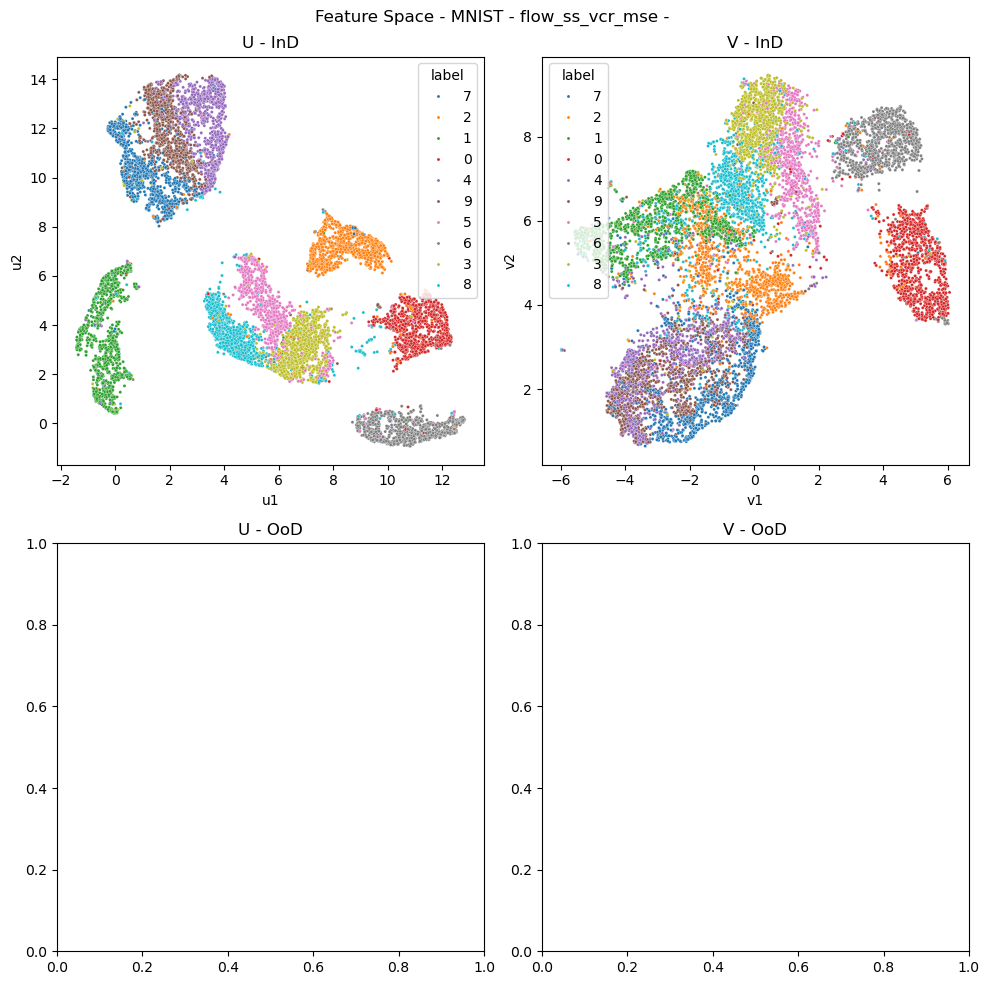

In [12]:
# plot feature space
ind_labels = [config.labels[i] for i in ind_tgt]
df_emb2d = pd.DataFrame()
u1, u2 = ind_e_u2d.T
v1, v2 = ind_e_v2d.T
df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ind_labels, source="ind"))])

if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]
    u1, u2 = ood_e_u2d.T
    v1, v2 = ood_e_v2d.T
    df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ood_labels, source="ood"))])

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
ax1.set_title("U - InD")
ax2.set_title("V - InD")
ax3.set_title("U - OoD")
ax4.set_title("V - OoD")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="u1", y="u2", hue="label", s=5, ax=ax1)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="v1", y="v2", hue="label", s=5, ax=ax2)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="u1", y="u2", hue="label", s=5, ax=ax3)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="v1", y="v2", hue="label", s=5, ax=ax4)
plt.tight_layout()
plt.show()

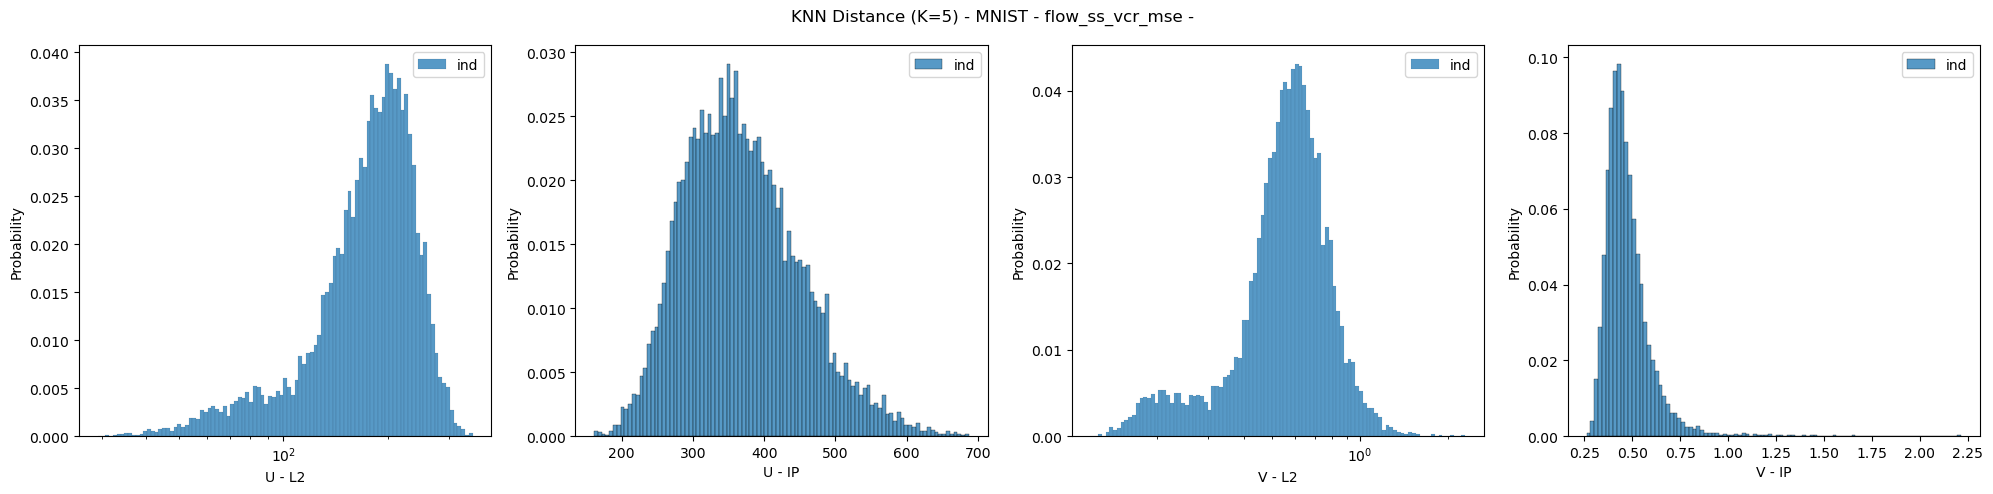

In [13]:
# plot knn distance from ind/ood to val data
def plot_knn_dists(index_fn, ax, trn_data, val_data, ind_data, ood_data=None, k=5, scale="linspace"):
    stats = {}
    index = index_fn(trn_data.shape[-1])
    index.add(trn_data)
    Dv = index.search(val_data, k)[0].mean(-1)
    Di = index.search(ind_data, k)[0].mean(-1)
    D = [Di]
    T = [[0] * Di.shape[0]]
    if ood_str:
        Do = index.search(ood_data, k)[0].mean(-1)
        D.append(Do)
        T.append([1] * Do.shape[0]) 
    D = np.concatenate(D, axis=0)
    T = np.concatenate(T, axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    prefix = ""
    if ood_str:
        Ci = np.histogram(Di, bins, density=True)[0]
        Co = np.histogram(Do, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(Do, Di)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
        ax.set_title(f"KL={kld:.4f} EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc, val_data=Dv.tolist(), ind_data=Di.tolist(), ood_data=Do.tolist()))
        
    if scale == "logspace":
        ax.set_xscale('log')
    ax.legend()
    return stats

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"KNN Distance (K=5) - {dataset_name} - {model_name} - {ood_str}")
run_stats["knn_u_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[0], trn_e_u, val_e_u, ind_e_u, ood_e_u if ood_str else None, scale="logspace")
axs[0].set_xlabel("U - L2")
run_stats["knn_u_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[1], trn_e_u, val_e_u, ind_e_u, ood_e_u if ood_str else None, scale="linspace")
axs[1].set_xlabel("U - IP")
run_stats["knn_v_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[2], trn_e_v, val_e_v, ind_e_v, ood_e_v if ood_str else None, scale="logspace")
axs[2].set_xlabel("V - L2")
run_stats["knn_v_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[3], trn_e_v, val_e_v, ind_e_v, ood_e_v if ood_str else None, scale="linspace")
axs[3].set_xlabel("V - IP")
plt.tight_layout()
plt.show()

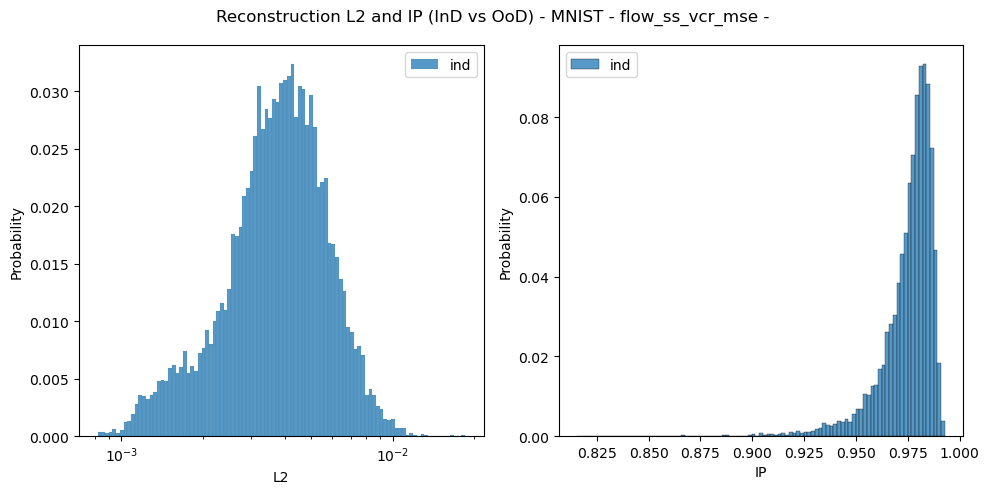

In [14]:
# plot reconstruction-based ood metrics
def plot_rcn(val_rcn, ind_rcn, ood_rcn, ax, scale="linspace"):
    stats = {}
    D = ind_rcn
    if ood_str:
        D = np.concatenate([ind_rcn, ood_rcn], axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(ind_rcn, label="ind", stat="probability", bins=bins, ax=ax)
    if ood_str:
        sns.histplot(ood_rcn, label="ood", stat="probability", bins=bins, ax=ax)
        T = np.concatenate([[0]*ind_rcn.shape[0],[1]*ood_rcn.shape[0]], axis=0)
        Ci = np.histogram(ind_rcn, bins, density=True)[0]
        Co = np.histogram(ood_rcn, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(ood_rcn, ind_rcn)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        ax.set_title(f"KL={kld:.4f}, EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc, val_data=val_rcn.tolist(), ind_data=ind_rcn.tolist(), ood_data=ood_rcn.tolist()))
    if scale == "logspace":
        ax.set_xscale("log")
    ax.legend()
    return stats

flatten = lambda x: x.reshape((x.shape[0], -1))
unit = lambda x: x / (np.linalg.norm(x, axis=-1, keepdims=True) + 1e-7)


# training data
_val_inp, _val_rcn = flatten(val_inp), flatten(val_rcn)
_val_inp_unit, _val_rcn_unit = unit(_val_inp), unit(_val_rcn)
# metrics
val_rcn_l2 = ((_val_inp - _val_rcn) ** 2).mean(-1)
val_rcn_ip = (_val_inp_unit * _val_rcn_unit).sum(-1)

# ind test data
_ind_inp, _ind_rcn = flatten(ind_inp), flatten(ind_rcn)
_ind_inp_unit, _ind_rcn_unit = unit(_ind_inp), unit(_ind_rcn)
# metrics
ind_rcn_l2 = ((_ind_inp - _ind_rcn) ** 2).mean(-1)
ind_rcn_ip = (_ind_inp_unit * _ind_rcn_unit).sum(-1)

if ood_str:
    # ood test data
    _ood_inp, _ood_rcn = flatten(ood_inp), flatten(ood_rcn)
    _ood_inp_unit, _ood_rcn_unit = unit(_ood_inp), unit(_ood_rcn)
    # metrics
    ood_rcn_l2 = ((_ood_inp - _ood_rcn) ** 2).mean(-1)
    ood_rcn_ip = (_ood_inp_unit * _ood_rcn_unit).sum(-1)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
run_stats["rcn_l2"] = plot_rcn(val_rcn_l2, ind_rcn_l2, ood_rcn_l2 if ood_str else None, ax1, scale="logspace")
ax1.set_xlabel("L2")
run_stats["rcn_ip"] = plot_rcn(val_rcn_ip, ind_rcn_ip, ood_rcn_ip if ood_str else None, ax2, scale="linspace")
ax2.set_xlabel("IP")
plt.suptitle(f"Reconstruction L2 and IP (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

In [15]:
# compute vector norms
trn_n_u = np.linalg.norm(trn_e_u, axis=-1)
trn_n_v = np.linalg.norm(trn_e_v, axis=-1)
val_n_u = np.linalg.norm(val_e_u, axis=-1)
val_n_v = np.linalg.norm(val_e_v, axis=-1)
ind_n_u = np.linalg.norm(ind_e_u, axis=-1)
ind_n_v = np.linalg.norm(ind_e_v, axis=-1)

if ood_str:
    ood_n_u = np.linalg.norm(ood_e_u, axis=-1)
    ood_n_v = np.linalg.norm(ood_e_v, axis=-1)

run_stats["norm_u"] = dict(val_data=val_n_u.tolist(), ind_data=ind_n_u.tolist(), ood_data=ood_n_u.tolist() if ood_str else None)
run_stats["norm_v"] = dict(val_data=val_n_v.tolist(), ind_data=ind_n_v.tolist(), ood_data=ood_n_v.tolist() if ood_str else None)

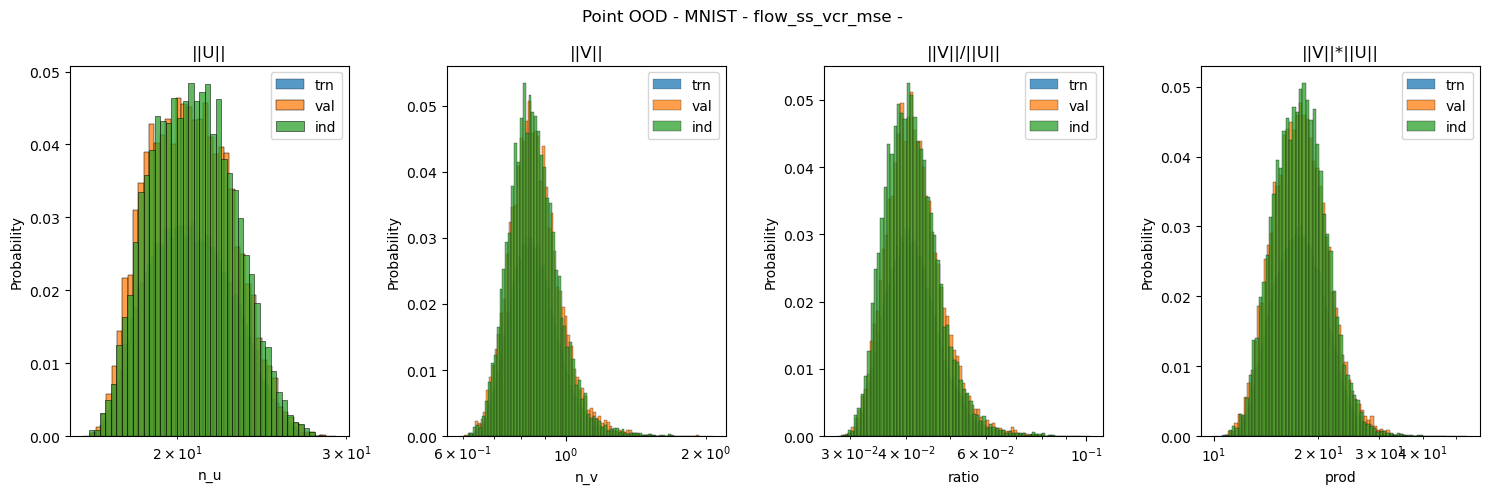

In [16]:
# plot pointwise ood metrics
df_trn = pd.DataFrame(dict(n_u=trn_n_u, n_v=trn_n_v, ratio=trn_n_v/trn_n_u, prod=trn_n_v*trn_n_u, target=trn_tgt))
df_val = pd.DataFrame(dict(n_u=val_n_u, n_v=val_n_v, ratio=val_n_v/val_n_u, prod=val_n_v*val_n_u, target=val_tgt))
df_ind = pd.DataFrame(dict(n_u=ind_n_u, n_v=ind_n_v, ratio=ind_n_v/ind_n_u, prod=ind_n_v*ind_n_u, target=ind_tgt))
if ood_str:
    df_ood = pd.DataFrame(dict(n_u=ood_n_u, n_v=ood_n_v, ratio=ood_n_v/ood_n_u, prod=ood_n_v*ood_n_u, target=ood_tgt))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (15, 5))
fig.suptitle(f"Point OOD - {dataset_name} - {model_name} - {ood_str}")

def plot_row(prop, ax):
    sns.histplot(data=df_trn, x=prop, log_scale=True, fill=True, label='trn', stat='probability', ax=ax)
    sns.histplot(data=df_val, x=prop, log_scale=True, fill=True, label='val', stat='probability', ax=ax)
    sns.histplot(data=df_ind, x=prop, log_scale=True, fill=True, label='ind', stat='probability', ax=ax)
    if ood_str:
        sns.histplot(data=df_ood, x=prop, log_scale=True, fill=True, label='ood', stat='probability', ax=ax)
    ax.legend()

plot_row("n_u", ax1)
plot_row("n_v", ax2)
plot_row("ratio", ax3)
plot_row("prod", ax4)
ax1.title.set_text('||U||')
ax2.title.set_text('||V||')
ax3.title.set_text('||V||/||U||')
ax4.title.set_text('||V||*||U||')

plt.tight_layout()
plt.show()

In [17]:
# organize data by class, aggregate groupwise
if ood_str:
    df_tst = pd.concat([df_ind, df_ood], axis=0)
else:
    df_tst = df_ind

all_targets = list(df_tst['target'].unique())
K = len(all_targets)
N = 128
rw, rh = 2, 0.75
colors = sns.color_palette(n_colors=K)

pointwise_trn = {}
pointwise_val = {}
pointwise_tst = {}

groupwise_trn = {}
groupwise_val = {}
groupwise_tst = {}

for i in range(K):
    _trn = df_trn[df_trn['target'] == all_targets[i]]
    _val = df_val[df_val['target'] == all_targets[i]]
    _tst = df_tst[df_tst['target'] == all_targets[i]]
    pointwise_trn[i] = _trn.copy()
    pointwise_val[i] = _val.copy()
    pointwise_tst[i] = _tst.copy()
    groupwise_trn[i] = _trn.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_val[i] = _val.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_tst[i] = _tst.rolling(N).agg(['mean', 'std']).dropna().copy()


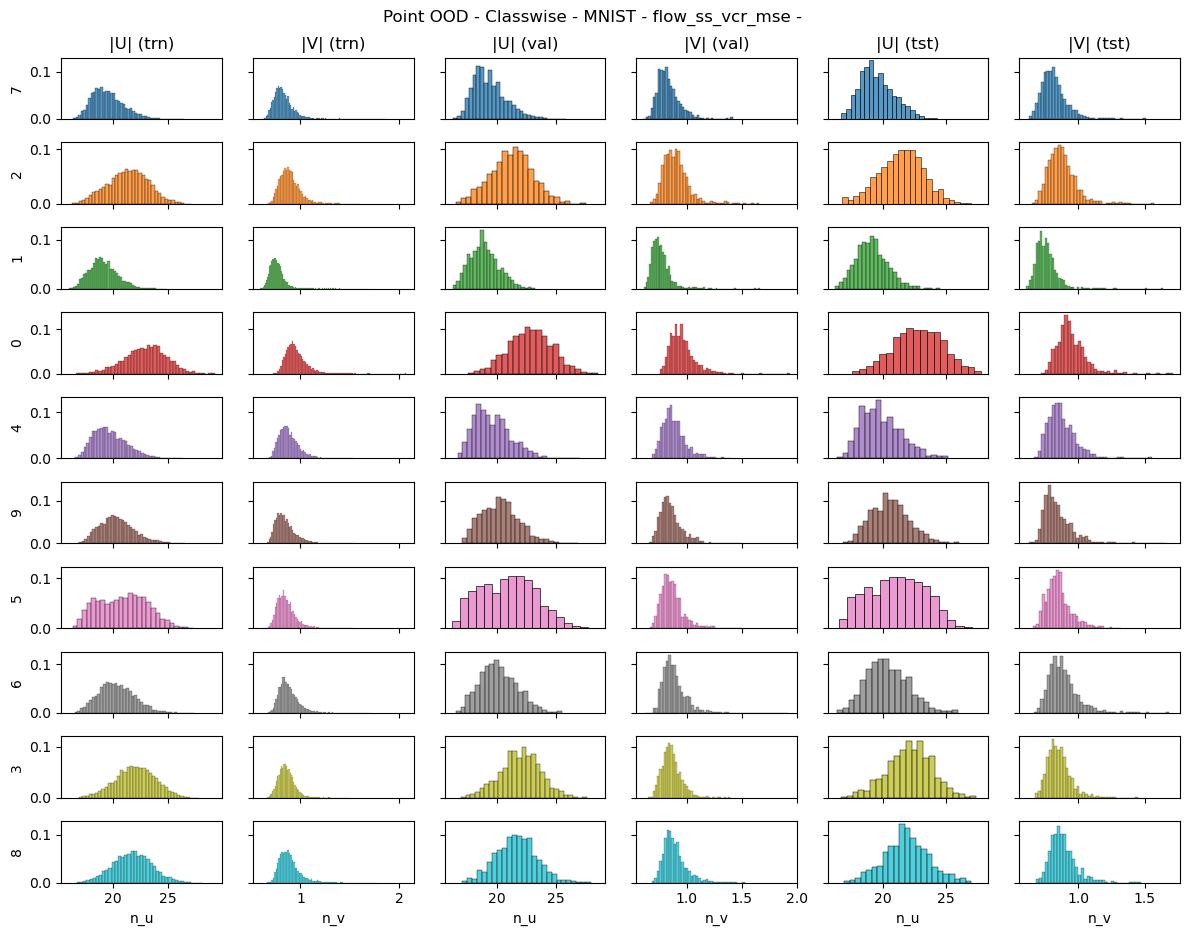

In [18]:
# plot per-class pointwise ood metrics
fig, axs = plt.subplots(K, 6, figsize=(6*rw, K*rh+2), sharex='col', sharey='row')
fig.suptitle(f"Point OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in range(K):
    _trn = pointwise_trn[i]
    _val = pointwise_val[i]
    _tst = pointwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax1)
        sns.histplot(data=_trn, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax3)
        sns.histplot(data=_val, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax5)
        sns.histplot(data=_tst, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()

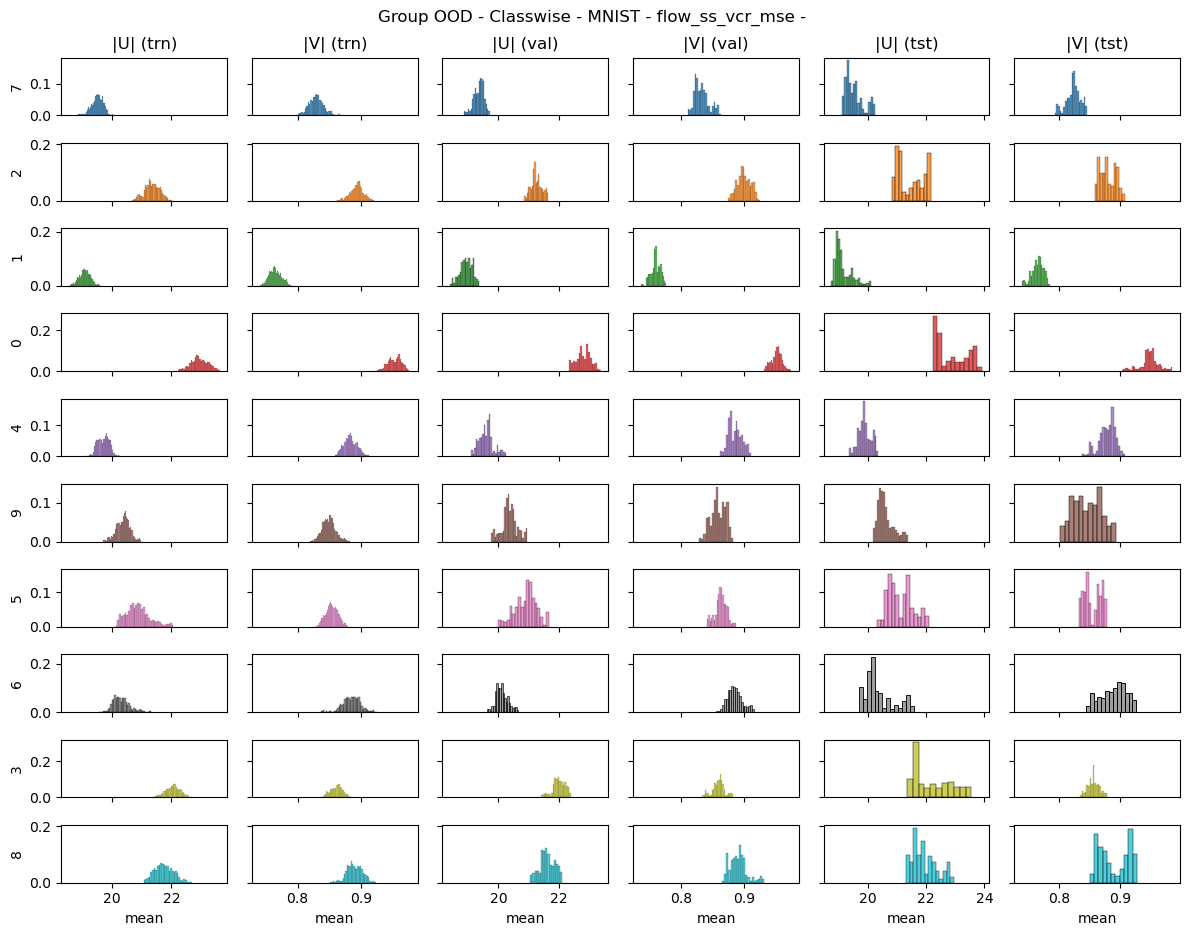

In [19]:
# plot per-class groupwise ood metrics
fig, axs = plt.subplots(K, 6, figsize = (6*rw, K*rh+2), sharex='col', sharey='row')
fig.suptitle(f"Group OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in all_targets:
    _trn = groupwise_trn[i]
    _val = groupwise_val[i]
    _tst = groupwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax1)
        sns.histplot(data=_trn.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax3)
        sns.histplot(data=_val.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax5)
        sns.histplot(data=_tst.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()

In [20]:
run_stats.update(dict(dataset_name=dataset_name, model_name=model_name, ood=ood))

import json
from datetime import datetime
with open(f"assets/results/{datetime.now()}.json", "w") as f:
    json.dump(run_stats, f)